In [ ]:
import datetime as dt

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.linear_model import Lasso, LinearRegression, Ridge
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler

from xgboost import XGBRegressor
import xgboost

In [ ]:
# read the data into a dataframe

df = pd.read_csv("/content/revisedweather.csv")

FileNotFoundError: [Errno 2] No such file or directory: '/content/revisedweather.csv'

In [ ]:
df.info()

In [ ]:
df.describe()

## Feature Engineering

In [ ]:
# create cyclic features for dayYear and hourDay
df['dayYear_sin'] = np.sin(2 * np.pi * df['dayYear'] / 365.25)
df['dayYear_cos'] = np.cos(2 * np.pi * df['dayYear'] / 365.25)
df['hourDay_sin'] = np.sin(2 * np.pi * df['hourDay'] / 24.0)
df['hourDay_cos'] = np.cos(2 * np.pi * df['hourDay'] / 24.0)

# extracting year from dt and creating a new column "year"
df['year'] = pd.to_datetime(df['dt']).dt.year

# dropping NaN values
df = df.dropna(axis=0, how="any")

# train / test split (test set - 17th September to 30th September)
train_df = df.iloc[:-14*24]
test_df = df.iloc[-14*24:]

# features to drop
drop_cols = ['y', 'dt', 'dt_iso', 'datetime_est',          # irrelevant
             'feels_like', 'temp', 'temp_min', 'temp_max', # data leakage
             'dayYear', 'hourDay']                         # use cyclic features instead

# features and target split
X_train = train_df.drop(columns=drop_cols)
y_train = train_df['y']
X_test = test_df.drop(columns=drop_cols)
y_test = test_df['y']

# final feature names
feature_names = X_train.columns.tolist()

# feature scaling (for LASSO/Ridge)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.values)
X_test_scaled = scaler.transform(X_test.values)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

MessageError: Error: credential propagation was unsuccessful

## Linear Regression

In [ ]:
model = LinearRegression()

model.fit(X_train, y_train)

y_pred_lin = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred_lin)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred_lin)

print(f"Mean MSE: {mse:.3f}")
print(f"Mean RMSE: {rmse:.3f}")
print(f"Mean R2: {np.mean(r2):.23}")

Mean MSE: 2.733
Mean RMSE: 1.653
Mean R2: 0.95570439460218747917963


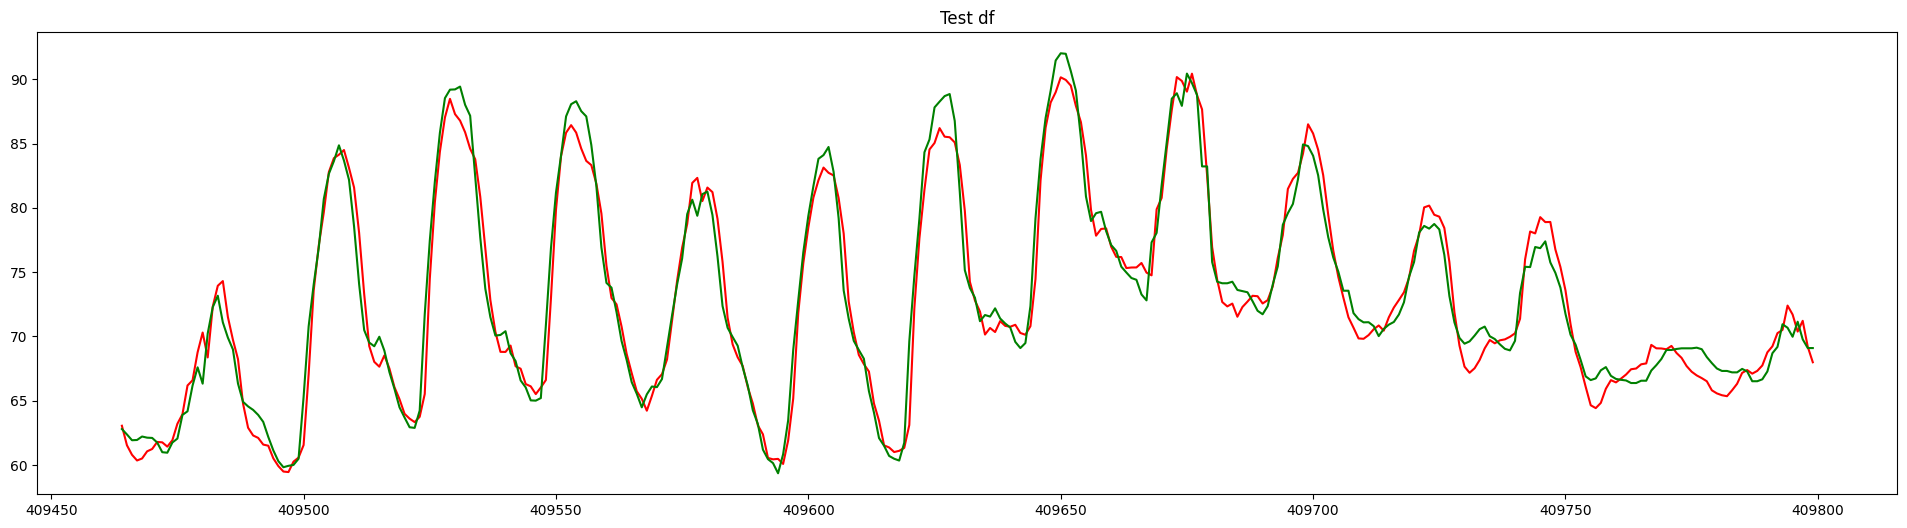

In [ ]:
plt.figure(figsize=(24, 6))
plt.plot(y_test.index, y_pred_lin, 'r')
plt.plot(y_test.index, y_test, 'g')
plt.title("Test df")
plt.show();

## Ridge Regression

In [ ]:
# Using GridSearchCV for alpha
ridge = Ridge(random_state=0)
ridge_params = {'alpha': [0.01, 0.1, 1.0, 10.0, 100.0]}
ridge_cv = GridSearchCV(ridge, ridge_params, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

ridge_cv.fit(X_train_scaled, y_train)

best_ridge = ridge_cv.best_estimator_
y_pred_ridge = best_ridge.predict(X_test_scaled)

mse_ridge = mean_squared_error(y_test, y_pred_ridge)
rmse_ridge = np.sqrt(mse_ridge)
r2_ridge = r2_score(y_test, y_pred_ridge)

print("Ridge Regression metrics")
print(f"Best alpha: {ridge_cv.best_params_['alpha']}")
print(f"Mean MSE: {mse_ridge:.3f}")
print(f"Mean RMSE: {rmse_ridge:.3f}")
print(f"Mean R2: {r2_ridge:.6f}")
print()

Ridge Regression metrics
Best alpha: 1.0
Mean MSE: 2.733
Mean RMSE: 1.653
Mean R2: 0.955704



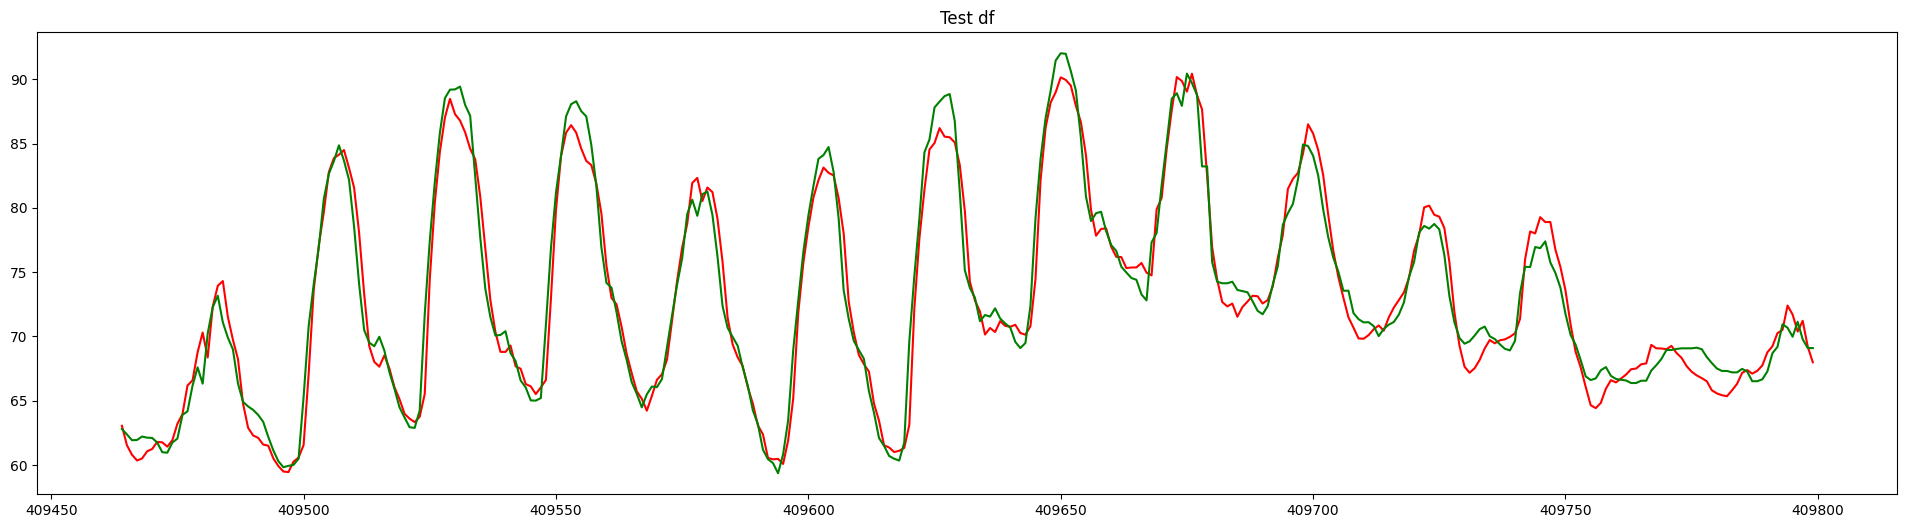

In [ ]:
plt.figure(figsize=(24, 6))
plt.plot(y_test.index, y_pred_ridge, 'r')
plt.plot(y_test.index, y_test, 'g')
plt.title("Test df")
plt.show();

## LASSO Regression

In [ ]:
# Lasso Regression using GridSearchCV for alpha
lasso = Lasso(max_iter=20000, random_state=0)
lasso_params = {'alpha': [0.0001, 0.001, 0.01, 0.1, 1.0]}
lasso_cv = GridSearchCV(lasso, lasso_params, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

lasso_cv.fit(X_train_scaled, y_train)

best_lasso = lasso_cv.best_estimator_
y_pred_lasso = best_lasso.predict(X_test_scaled)

mse_lasso = mean_squared_error(y_test, y_pred_lasso)
rmse_lasso = np.sqrt(mse_lasso)
r2_lasso = r2_score(y_test, y_pred_lasso)

print("Lasso Regression metrics")
print(f"Best alpha: {lasso_cv.best_params_['alpha']}")
print(f"Mean MSE: {mse_lasso:.3f}")
print(f"Mean RMSE: {rmse_lasso:.3f}")
print(f"Mean R2: {r2_lasso:.6f}")
print()

Lasso Regression metrics
Best alpha: 0.0001
Mean MSE: 2.733
Mean RMSE: 1.653
Mean R2: 0.955703



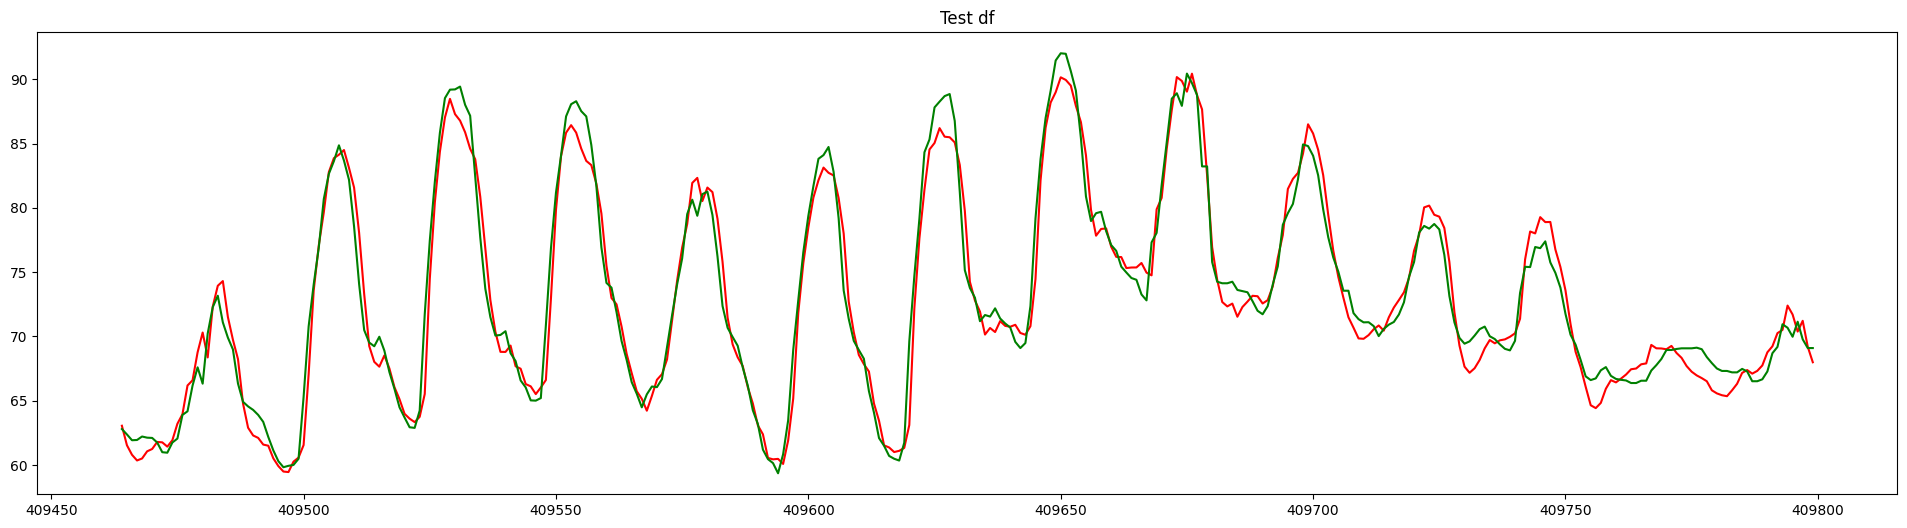

In [ ]:
plt.figure(figsize=(24, 6))
plt.plot(y_test.index, y_pred_lasso, 'r')
plt.plot(y_test.index, y_test, 'g')
plt.title("Test df")
plt.show();

## XGBoost Model

In [ ]:
xgb = XGBRegressor(objective='reg:squarederror', random_state=0, n_jobs=-1, verbosity=0)
xgb_params = {
    'n_estimators': [100, 300],
    'max_depth': [3, 6],
    'learning_rate': [0.05, 0.1]
}
xgb_cv = GridSearchCV(xgb, xgb_params, cv=3, scoring='neg_mean_squared_error', n_jobs=-1)

xgb_cv.fit(X_train, y_train)

best_xgb = xgb_cv.best_estimator_
y_pred_xgb = best_xgb.predict(X_test)

mse_xgb = mean_squared_error(y_test, y_pred_xgb)
rmse_xgb = np.sqrt(mse_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)

print("XGBoost metrics")
print(f"Best params: {xgb_cv.best_params_}")
print(f"Mean MSE: {mse_xgb:.3f}")
print(f"Mean RMSE: {rmse_xgb:.3f}")
print(f"Mean R2: {r2_xgb:.6f}\n")

XGBoost metrics
Best params: {'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 300}
Mean MSE: 1.270
Mean RMSE: 1.127
Mean R2: 0.979421



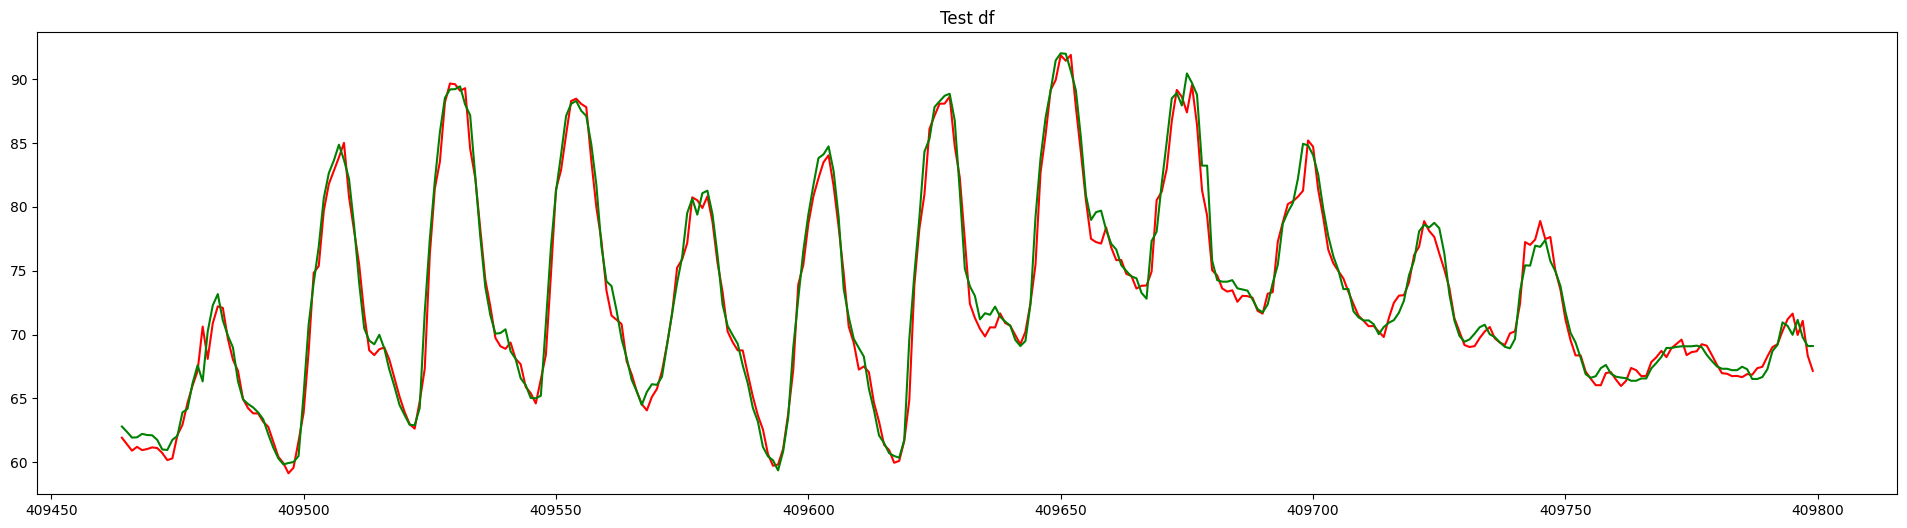

In [ ]:
plt.figure(figsize=(24, 6))
plt.plot(y_test.index, y_pred_xgb, 'r')
plt.plot(y_test.index, y_test, 'g')
plt.title("Test df")
plt.show();